In [1]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import os

In [2]:
def get_images_array(imageFile, dataPath):
    with open(imageFile, "r") as f:
        images =  []
        labels = []
        for image in f:
            image =image.replace("\n", "")
            if 'NonCOVID' in imageFile:
                image = imread(dataPath + '/CT_NonCOVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(0)
            else:
                image = imread(dataPath + '/CT_COVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(1)
        return images,labels
            

In [3]:
base_dir= '../../../data/'
train_im, train_labels = get_images_array(base_dir+'/Data-split/COVID/trainCT_COVID.txt', base_dir)
train_imNC, train_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/trainCT_NonCOVID.txt', base_dir)
train_im.extend(train_imNC)
train_labels.extend(train_labels_nc)

train_features = np.array(train_im)
train_labels = np.int64(np.array(train_labels))

test_im, test_labels = get_images_array(base_dir+'/Data-split/COVID/testCT_COVID.txt', base_dir)
test_im_nc, test_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/testCT_NonCOVID.txt', base_dir)
test_im.extend(test_im_nc)
test_labels.extend(test_labels_nc)

test_features = np.array(test_im)
test_labels = np.int64(np.array(test_labels))

print(train_features.shape)

(425, 200, 200)


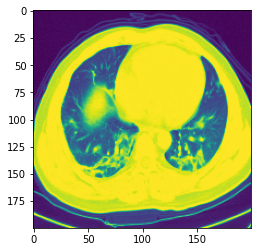

In [4]:
plt.imshow(train_im[0])

In [24]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_labels, test_size = 0.1)

print(train_y)
train_x = train_x.reshape(382, 1, 200, 200)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

val_x = val_x.reshape(43, 1, 200, 200)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

test_features = test_features.reshape(203, 1, 200, 200)
test_x = torch.from_numpy(test_features)
test_y = torch.from_numpy(test_labels)
train_x.shape, test_x.shape, val_x.shape

[0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0
 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0
 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 0 1]
(425, 200, 200)


In [6]:
class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(10000, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
model = CNN()
print(model)
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
#if torch.cuda.is_available():
    #model = model.cuda()
    #criterion = criterion.cuda()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10000, out_features=10, bias=True)
  )
)


In [8]:
def train_cnn():
    model.train()
    loss = 0
    trainx = Variable(train_x)
    trainy = Variable(train_y)
    valx = Variable(val_x)
    valy = Variable(val_y)
   #if torch.cuda.is_available():
     #   trainx = trainx.cuda()
     #   trainy = trainy.cuda()
     #   valx = valx.cuda()
     #   valy = valx.cuda()
    optimizer.zero_grad()
    train_out = model(trainx)
    val_out = model(valx)
    train_loss = criterion(train_out, trainy)
    val_loss = criterion(val_out, valy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_loss.backward()
    optimizer.step()
    loss = train_loss.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', val_loss)
    return val_loss

In [9]:
print()

In [10]:
n_epochs = 100
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_cnn()

Epoch :  1 	 loss : tensor(2.2210, grad_fn=<NllLossBackward>)
Epoch :  2 	 loss : tensor(0.7443, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(33.8663, grad_fn=<NllLossBackward>)
Epoch :  4 	 loss : tensor(79.0961, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(41.3911, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(44.1086, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(57.9892, grad_fn=<NllLossBackward>)
Epoch :  8 	 loss : tensor(39.2127, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(21.8414, grad_fn=<NllLossBackward>)
Epoch :  10 	 loss : tensor(27.4332, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(29.6943, grad_fn=<NllLossBackward>)
Epoch :  12 	 loss : tensor(21.4361, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(10.5021, grad_fn=<NllLossBackward>)
Epoch :  14 	 loss : tensor(6.4673, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(8.5991, grad_fn=<NllLossBackward>)
Epoch :  16 	 loss : tensor(9.2784, grad_fn=<NllLossB

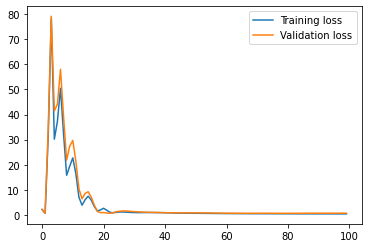

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [12]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)
print(train_y)
# accuracy on training set
accuracy_score(train_y, predictions)

[0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0
 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0
 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0
 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0
 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1
 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1
 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 1]
tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,

0.756544502617801

In [13]:
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)
print(val_y)
# accuracy on validation set
accuracy_score(val_y, predictions)

[1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0
 1 1 1 1 0 1]
tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])


0.627906976744186

In [14]:
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)
print(test_y)
# accuracy on validation set
accuracy_score(test_y, predictions)

[1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0]
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0

0.645320197044335

In [15]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point.tolist())
    centroid = np.array(centroid.tolist())
    return np.linalg.norm(point - centroid)

In [16]:
def centroid(data):
    """Find the centroid for one class of object"""
    #print(data.shape)
    features, observations = data.shape
    if(features > observations):
        raise ValueError("too few observations")
    
    central = []
    for i in range(features):
        mean = torch.mean(data[i])
        central.append(mean)
    return torch.FloatTensor(central).to(device)

In [27]:
def split_classes(data, labels):
    """Split data into 2 classes based on corresponding label"""
    loan, not_loan = [], []
    for i in range(data.shape[0]):
        if(labels[i].item() == 0):#no loan
            not_loan.append(data[i].tolist())
        else:
            loan.append(data[i].tolist())
    loan = torch.tensor(loan).to(device)        
    not_loan = torch.tensor(not_loan).to(device)
    print(loan.shape)
    print(not_loan.shape)
    return loan, not_loan

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
covid_train, non_covid_train = split_classes(train_features, train_labels)
covid_test, non_covid_test = split_classes(test_features, test_labels)
print(train_features.shape)

torch.Size([191, 200, 200])
torch.Size([234, 200, 200])
torch.Size([98, 1, 200, 200])
torch.Size([105, 1, 200, 200])
(425, 200, 200)


In [22]:
covid_centroid, not_covid_centroid = centroid(covid), centroid(not_covid)

torch.Size([191, 200, 200])


ValueError: too many values to unpack (expected 2)